# ECE 417 Lecture 15: Expectation Maximization
## Mark Hasegawa-Johnson, October 17, 2017
This file is distributed under a <a href="https://creativecommons.org/licenses/by/3.0/">CC-BY</a> license.  You may freely re-use or re-distribute the whole or any part.  If you re-distribute a non-trivial portion of it, give me credit.

## Outline of Today's lecture
* Preliminaries
* Always initialize a GMM from a Gaussian
* K-means clustering algorithm
* Expectation Maximization (EM)


# Preliminaries
First let's load some libraries, and some data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import requests
%matplotlib inline

In [2]:
# Download data from the UCI repository
r=requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
# Split at every newline; split each line at commas
dataset = [ x.split(',') for x in r.text.split('\n') ]
dataset[0::50]

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'],
 ['6.3', '3.3', '6.0', '2.5', 'Iris-virginica'],
 ['']]

In [3]:
# Get a dictionary from labels t indices, and back again
label2class = { 'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 }
class2label = { 0:'Iris-setosa', 1:'Iris-versicolor', 2:'Iris-virginica' }
# Read out a list of the class labels, convert to integers
Y = [ label2class[x[4]] for x in dataset if len(x)==5 ]
Y[0::50]

[0, 1, 2]

In [4]:
# Create a numpy arrays for each data subset
X = np.array([ x[0:4] for x in dataset if len(x)==5 ], dtype='float64')
X[0::20]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5. ,  3.5,  1.3,  0.3],
       [ 5. ,  2. ,  3.5,  1. ],
       [ 5.5,  2.4,  3.8,  1.1],
       [ 6.3,  3.3,  6. ,  2.5],
       [ 6.9,  3.2,  5.7,  2.3],
       [ 6.7,  3.1,  5.6,  2.4]])

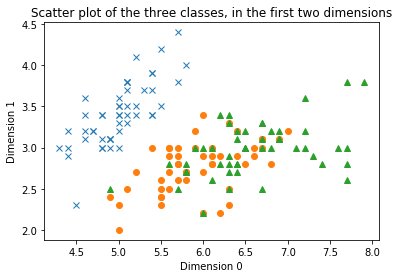

In [5]:
# Plot a scatter plot of the three classes, so we can see how well they separate in the first two dimensions
plt.plot(X[1:50,0],X[1:50,1],'x',X[50:100,0],X[50:100,1],'o',
        X[100:150,0],X[100:150,1],'^')
plt.title('Scatter plot of the three classes, in the first two dimensions')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')

# Always Initialize a GMM from a Gaussian
Remember from last time that the pdf for a GMM is
$$p_{X|Y}(\vec{x}|y)=\sum_{k=1}^K c_{yk}{\mathcal N}(\vec{x};\vec\mu_{yk},\Sigma_{yk})$$

Finding the parameters $\vec\mu_{yk}$ and $\Sigma_{yk}$ is a little tricky.  You'll almost always get the best results if you first find the mean and covariance of each Gaussian.

In [6]:
# Compute the mean of each class.  axis=0 means to compute the average row vector 
mu=np.empty((3,2))
for y in range(0,3):
    mu[y,:] = np.mean(X[50*y:50*(y+1),0:2],axis=0)

In [7]:
# Compute the covariance of each class.
Sigma = np.empty((3,2,2))
for y in range(0,3):
    Sigma[y,:,:] = np.cov(X[50*y:50*(y+1),0:2],rowvar=False)


In [8]:
# Create a coordinate system on which we can calculate the Gaussian pdf
coords = np.mgrid[4:8:0.01,2:4.5:0.01].transpose((1,2,0))

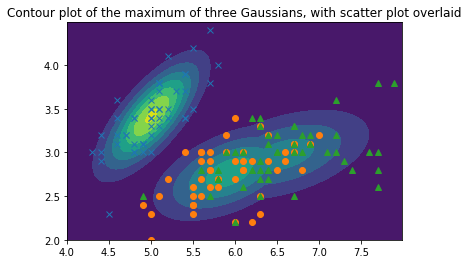

In [9]:
# Calculate the Gaussian pdfs at the same set of points
pdf = np.empty((400,250,3))
for y in range(0,3):
    pdf[:,:,y] = stats.multivariate_normal(mu[y,:],Sigma[y,:,:]).pdf(coords)
ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],np.amax(pdf,axis=2))
ax.plot(X[0:50,0],X[0:50,1],'x',X[50:100,0],X[50:100,1],'o',X[100:150,0],X[100:150,1],'^')
plt.title('Contour plot of the maximum of three Gaussians, with scatter plot overlaid')

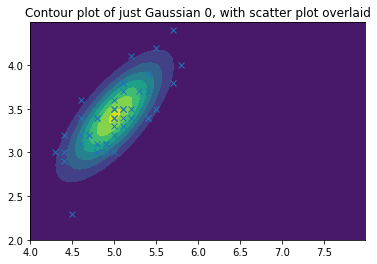

In [10]:
ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],pdf[:,:,0])
ax.plot(X[0:50,0],X[0:50,1],'x')
plt.title('Contour plot of just Gaussian 0, with scatter plot overlaid')

### Principal Components
It's going to be useful, in a few minutes, if we know the principal components of each of these three Gaussians.  Remember that the PCA directions, $\vec{v}_{yi}$, and variances, $\lambda_{yi}$, are the eigenvectors and eigenvalues of the covariance matrix:
$$\lambda_{yi},\vec{v}_{yi}=\mbox{eig}(\Sigma_y)$$

which means that
$$\Sigma_y \vec{v}_{yi}=\lambda_{yi}\vec{v}_{yi}$$

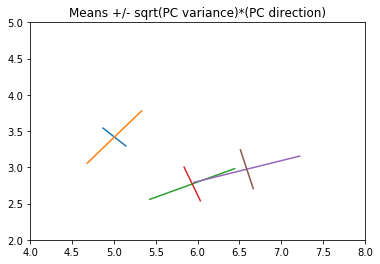

In [11]:
# Find the principal component directions and variances of each Gaussia
Lambda, V = np.linalg.eig(Sigma)

# Let's show the mean vectors plus/minus each variance-scaled principal component direction
ax=plt.gca()
plt.xlim(4,8)
plt.ylim(2,5)
plt.title('Means +/- sqrt(PC variance)*(PC direction)')
for y in range(0,3):
    for i in range(0,2):
        x0 = mu[y,0]+np.sqrt(Lambda[y,i])*np.array([-V[y,0,i],V[y,0,i]])
        x1 = mu[y,1]+np.sqrt(Lambda[y,i])*np.array([-V[y,1,i],V[y,1,i]])
        ax.plot(x0,x1)

### Now initialize the GMM

Now we're going to initialize the GMM.  We'll create two Gaussians per class.  Each of the two Gaussians will have exactly the same covariance matrix and exactly the same mixture weight, but they will have slightly different mean vectors, set at $$\vec\mu_{y0}=\vec\mu_y+0.1\sqrt{\lambda_{y0}}\vec{v}_{y0}$$

and at $$\vec\mu_{y1}=\vec\mu_y-0.1\sqrt{\lambda_{y0}}\vec{v}_{y0}$$


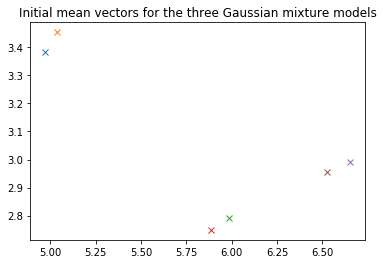

In [12]:
mu_gmm = np.empty((3,2,2))
Sigma_gmm = np.empty((3,2,2,2))
c_gmm = np.empty((3,2))
ax = plt.gca()
plt.title('Initial mean vectors for the three Gaussian mixture models')
for y in range(0,3):
    # We need to find the maximum eigenvalue, because numpy doesn't sort them
    imax = np.argmax(Lambda[y,:])
    #imax=0
    for k in range(0,2):
        mu_gmm[y,k,:]=mu[y,:] + (-1)**k * 0.1*np.sqrt(Lambda[y,imax])*V[y,:,imax]
        Sigma_gmm[y,k,:,:]=Sigma[y,:,:]
        c_gmm[y,k] = 0.5
        ax.plot(mu_gmm[y,k,0],mu_gmm[y,k,1],'x')

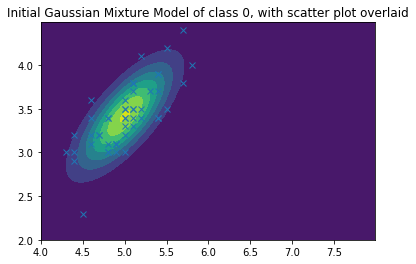

In [13]:
# Now let's calculate the GMM model of each of the three classes
gmm_gaussians = np.empty((400,250,3,2))
gmm_pdf = np.zeros((400,250,3))
for y in range(0,3):
    for k in range(0,2):
        gmm_gaussians[:,:,y,k] = stats.multivariate_normal(mu_gmm[y,k,:],Sigma_gmm[y,k,:,:]).pdf(coords)
        gmm_pdf[:,:,y] = gmm_pdf[:,:,y] + c_gmm[y,k]*gmm_gaussians[:,:,y,k]

ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],gmm_pdf[:,:,0])
ax.plot(X[0:50,0],X[0:50,1],'x')
plt.title('Initial Gaussian Mixture Model of class 0, with scatter plot overlaid')

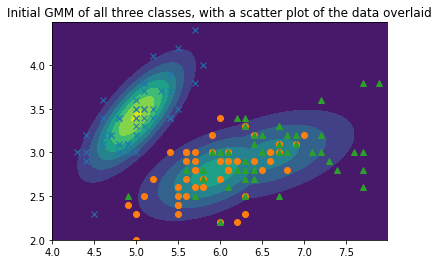

In [14]:
ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],np.amax(gmm_pdf,axis=2))
ax.plot(X[0:50,0],X[0:50,1],'x',X[50:100,0],X[50:100,1],'o',X[100:150,0],X[100:150,1],'^')
plt.title('Initial GMM of all three classes, with a scatter plot of the data overlaid')

# Re-training the GMMs: K-means clustering

K-means clustering is an algorithm that clusters some input data vectors, $\vec{x}_n$, into $K$ different clusters.

The algorithm alternates between two steps.
1. Each datum is assigned to the cluster with the closest centroid:
$$ k(n) = \arg\min\Vert \vec{x}_n-\vec\mu_k\Vert$$

2. Each cluster centroid is re-estimated as the average of the data in its cluster:
$$ \vec\mu_k = \frac{1}{N_k} \sum_{n:k(n)=k}\vec{x}_n$$

We go back and forth betwen these two steps until the total cluster distance, $D$, stops decreasing, where
$$D = \sum_{n=1}^N \Vert \vec{x}_n-\vec\mu_{k(n)}\Vert^2$$


All of these steps have to be done separately for each of the three classes.

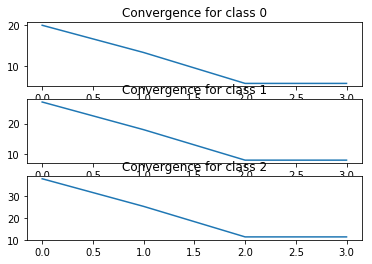

In [15]:
for y in range(0,3):
    # Perform K-means clustering for the y'th class
    # Start out with the dummy assumption that all data are in the 0'th cluster
    Xy = X[50*y:50*(y+1),0:2]
    k_index = np.zeros((50),dtype='int')
    # Find the resulting value of D, then set Dprev to 100 times that
    D = np.zeros((2))
    for n in range(0,50):
        D[-1] = D[-1] + np.sum(np.square(Xy[n,:]-mu_gmm[y,k_index[n],:]))
    D[0] = 1.5*D[-1]

    # Now iterate until convergence
    while D[-2]-D[-1] > 0.05*D[-2]:
        # Assign each datum to the nearest cluster
        for n in range(0,50):
            d0 = np.linalg.norm(Xy[n,0:2]-mu_gmm[y,0,:])
            d1 = np.linalg.norm(Xy[n,0:2]-mu_gmm[y,1,:])
            k_index[n]= np.argmin([d0,d1])
        # Now re-compute the centers (and the variances), based on the data assigned to each one
        for k in range(0,2):
            c_gmm[y,k] = np.count_nonzero(k_index==k)/50
            mu_gmm[y,k,:]=np.mean(Xy[k_index==k,:],axis=0)
            Sigma_gmm[y,k,:,:]=np.cov(Xy[k_index==k,:],rowvar=False)
        # Re-calculate D
        D = np.append(D,[0])
        for n in range(0,50):
            D[-1] = D[-1] + np.sum(np.square(Xy[n,:]-mu_gmm[y,k_index[n],:]))

    # After convergence, plot D
    plt.subplot(3,1,y+1)
    plt.plot(D)
    plt.title('Convergence for class {}'.format(y))


### The K-means algorithm is guaranteed to converge to a local minimum of D
Notice that we can be certain that the K-means algorithm converges, because both of the steps reduce the value of D.
* The first step assigns each datum to the nearest centroid.  Either a particular datum stays in the cluster it's already in, or it moves to a centroid that is closer, thus reducing the total value of D:
$$k(n)=\arg\min\Vert\vec{x}_n-\vec\mu_k\Vert^2$$
* The second step changes the mean, $\vec\mu_k$, to be the average of the data in the cluster.  But that's exactly the value that minimizes $D$!  In other words, the minimum-mean-squared error centroid, $\vec\mu_k$, is equal to the average of the data in the cluster:
$$\arg\min \sum_{n:k(n)=k}\Vert\vec{x}_n-\vec\mu_k\Vert^2 = \frac{1}{N_k}\sum_{n:k(n)=k}\vec{x}_n$$

Since each of the two steps either leaves $D$ unchanged or reduces $D$, therefore the algorithm only continues while it's possible to reduce $D$.

But this algorithm doesn't find the GLOBAL optimum, it only finds a LOCAL optimum.  It's possible that if you started with some other initial values of $\vec\mu_k$, you might end with an even lower value of D.

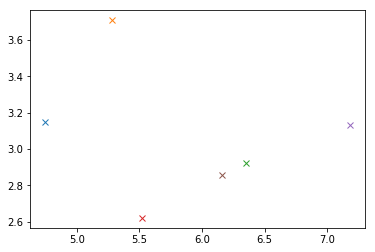

In [16]:
ax=plt.gca()
for y in range(0,3):
    for k in range(0,2):
        ax.plot(mu_gmm[y,k,0],mu_gmm[y,k,1],'x')

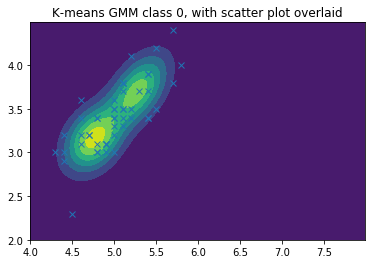

In [17]:
# Now let's calculate the GMM model of each of the three classes
gmm_gaussians = np.empty((400,250,3,2))
gmm_pdf = np.zeros((400,250,3))
for y in range(0,3):
    for k in range(0,2):
        gmm_gaussians[:,:,y,k] = stats.multivariate_normal(mu_gmm[y,k,:],Sigma_gmm[y,k,:,:]).pdf(coords)
        gmm_pdf[:,:,y] = gmm_pdf[:,:,y] + c_gmm[y,k]*gmm_gaussians[:,:,y,k]

ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],gmm_pdf[:,:,0])
ax.plot(X[0:50,0],X[0:50,1],'x')
plt.title('K-means GMM class 0, with scatter plot overlaid')

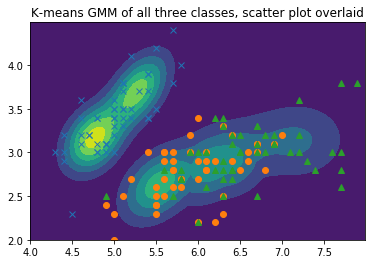

In [18]:
ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],np.amax(gmm_pdf,axis=2))
ax.plot(X[0:50,0],X[0:50,1],'x',X[50:100,0],X[50:100,1],'o',X[100:150,0],X[100:150,1],'^')
plt.title('K-means GMM of all three classes, scatter plot overlaid')

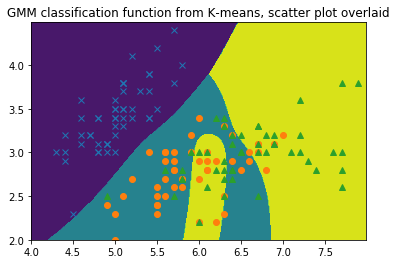

In [19]:
ax=plt.gca()
maxpdf = np.amax(gmm_pdf, axis=2)
yhat_using_em = (maxpdf == gmm_pdf[:,:,1]) + 2*(maxpdf == gmm_pdf[:,:,2])
ax.contourf(coords[:,:,0],coords[:,:,1],yhat_using_em)
ax.plot(X[0:50,0],X[0:50,1],'x',X[50:100,0],X[50:100,1],'o',X[100:150,0],X[100:150,1],'^')
plt.title('GMM classification function from K-means, scatter plot overlaid')

# Expectation Maximization (EM)
Did you notice: K-means can be used to calculate the mixture weights and covariance matrices, but it doesn't use them in the optimization?  The total distance, $D$, only depends on the means.

Expectation-Maximization (EM) uses a training criterion that uses all of the GMM parameters: Maximum Likelihood.

The "Log Likelihood of the Data given the Model" is
$${\mathcal L} = \ln p(X|Y,\Lambda)$$

where $$X=[\vec{x}_1,\vec{x}_2,\ldots]$$
$$Y=[y_1,y_2,\ldots]$$
and the parameters are $$\Lambda=\left\{c_{00},\ldots,\Sigma_{21}\right\}$$

If we assume that the observations are independent, given the parameters, then
$${\mathcal L}=\ln \prod_{n=0}^{N-1} p_{X|Y,\Lambda}(\vec{x}_n|y_n,\Lambda)$$


$${\mathcal L} = \ln \prod_{n=0}^{N-1} p_{X|Y}(\vec{x}_n|y_n)$$

where $y_n$ is the true class of the n'th datum, and of course
$${\mathcal L} = \sum_{n=0}^{N-1} \ln p_{X|Y}(\vec{x}_n|y_n)$$

So in other words,
$${\mathcal L} = \sum_{n=0}^{N-1} \ln\left(\sum_{k=0}^{K-1}c_{yk}{\mathcal N}(\vec{x}_n;\vec\mu_{yk},\Sigma_{yk})\right)$$



The EM algorithm finds the maximum likelihood model parameters.  Suppose we define the set of all model parameters to be
$$\Lambda = \left\{c_{00},\ldots,c_{21},\vec\mu_{00},\ldots,\vec\mu_{21},\Sigma_{00},\ldots,\Sigma_{21}\right\}$$

A "maximum likelihood" training algorithm is defined to be one that chooses the parameters in order to maximize the likelihood:
$$\Lambda^* = \arg\max {\mathcal L}(\Lambda)$$

### Why is the log useful?
The log is useful because it allows us to differentiate ${\mathcal L}$ with respect to any particular parameter,
and wind up with a derivative that has separate terms for each of the $N$ different data. 

Let me show you what I mean.  Suppose we tried to differentiate like this:
$$\frac{\partial}{\partial\vec\mu_{00}}\prod_{n=0}^{N-1}p_{X|Y}(\vec{x}_n|y_n)$$

... we would get a product form, with all of the terms for all different $\vec{x}_n$ multiplied together.  On the other hand, suppose we do this:
$$\frac{\partial}{\partial\vec\mu_{00}}\sum_{n=0}^{N-1}\ln p_{X|Y}(\vec{x}_n|y_n)$$

... we get the sum of individual derivatives, one for each $\vec{x}_n$:
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}} = \sum_{n=0}^{N-1}\frac{\partial}{\partial\vec\mu_{00}}\ln p_{X|Y}(\vec{x}_n|y_n)$$

OK, sure, but that last derivative is zero, unless the token $n$ is one that comes from class $y_n=0$.  So let's get rid of all of the other training tokens now, and focus only on the ones that come from class $y_n=0$.  For example, in the iris dataset, this would be the first $N_0=50$ tokens.  In general, let's say we're only summing the $N_0$ tokens for which $y_n=0$:
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}}=\sum_{n=0}^{N_0-1}\frac{\partial}{\partial\vec\mu_{00}}\ln p_{X|Y}(\vec{x}_n|y_n=0)$$

### Let's calculate that derivative
Let's calculate the derivative of the log-likelihood with respect to $\vec\mu_{00}$.  Continuing the equation above, we get
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}}=\sum_{n=0}^{N_0-1}\frac{\partial}{\partial\vec\mu_{00}}\ln\left(\sum_{k=0}^{K-1}c_{0k}
{\mathcal N}(\vec{x}_n;\vec\mu_{0k},\Sigma_{0k})\right)$$

The derivative of $\ln(x)$ is $\frac{1}{x}$!!  So
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}}=\sum_{n=0}^{N_0-1}\left(\frac{1}
{\sum_{k=0}^{K-1}c_{0k}{\mathcal N}(\vec{x}_n;\vec\mu_{0k},\Sigma_{0k})}\right)
c_{00}\frac{\partial \mathcal N(\vec{x}_n;\vec\mu_{00},\Sigma_{00})}{\partial\vec\mu_{00}}$$


The derivative of a Gaussian is actually not too hard to calculate, if we just expand it out:
$$\frac{\partial{\mathcal N}(\vec{x};\vec\mu,\Sigma)}{\partial\vec\mu}=
\frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\frac{\partial}{\partial\vec\mu}e^{-\frac{1}{2}d_\Sigma^2(\vec{x},\vec\mu)}$$

The derivative of $e^x$ is $e^x$!! So
$$\frac{\partial{\mathcal N}(\vec{x};\vec\mu,\Sigma)}{\partial\vec\mu}=
\frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}e^{-\frac{1}{2}d_\Sigma^2(\vec{x},\vec\mu)} \frac{\partial\left(-\frac{1}{2}d_\Sigma^2(\vec{x},\vec\mu)\right)}{\partial\vec\mu}={\mathcal N}(\vec{x};\vec\mu,\Sigma) \left(-\frac{1}{2}\frac{\partial d_\Sigma^2(\vec{x},\vec\mu)}{\partial\vec\mu_{00}}\right)$$

Remember that the Mahalanobis distance is
$$d_\Sigma^2(\vec{x},\vec\mu)=(\vec{x}-\vec\mu)^T\Sigma^{-1}(\vec{x}-\vec\mu)$$

You might never have seen the derivative of something like this before, but you've certainly seen the scalar version:
$$\frac{\partial}{\partial\mu_d}\left(\frac{(x_d-\mu_d)^2}{\sigma_d^2}\right)=2\frac{\mu_d-x_d}{\sigma_d^2}$$

The vector derivative is just the same thing:
$$\frac{\partial}{\partial\vec\mu}(\vec{x}-\vec\mu)^T\Sigma^{-1}(\vec{x}-\vec\mu)=
2\Sigma^{-1}(\vec\mu-\vec{x}))$$

So we get the very cool result that the derivative of a Gaussian is scaled by the Gaussian:
$$\frac{\partial{\mathcal N}(\vec{x};\vec\mu,\Sigma)}{\partial\vec\mu}=
{\mathcal N}(\vec{x};\vec\mu,\Sigma)\Sigma^{-1} (\vec{x}-\vec\mu)$$

Putting that all together, we have
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}}=
2\sum_{n=0}^{N_0-1}\left(\frac{c_{00}{\mathcal N}(\vec{x}_n;\vec\mu_{00},\Sigma_{00})}
{\sum_{k=0}^{K-1}c_{0k}{\mathcal N}(\vec{x}_{n};\vec\mu_{0k},\Sigma_{0k})}\right) \Sigma_{00}^{-1}\left(\vec{x}_n-\vec\mu_{00}\right)$$

### The gamma probability
The part in parentheses, above, shows up over and over again in algorithms related to the EM algorithm.  It is called the class-posterior, or more colloquially, the "gamma probability".

Let's parse what it means.  First, remember that the mixture weights sum to 1.  So the mixture weight can be interpreted as the probability of choosing the 0'th Gaussian:
$$c_0 = p_K(k=0)$$

OK, then second, the normal distribution is the likelihood of $\vec{x}$, given that we have chosen the 0'th Gaussian:
$${\mathcal N}(\vec{x};\vec\mu_0,\Sigma_0) = p_{X|K}(\vec{x}|k=0)$$

Then the summation in the denominator is kind of like a marginal pdf:
$$\sum_k c_k {\mathcal N}(\vec{x};\vec\mu_0,\Sigma_0)=\sum_k p_K(0)p_{X|K}(\vec{x}|0) = p_X(\vec{x})$$

So the whole term in  parentheses is like the posterior probability of choosing the 0'th Gaussian, given knowledge of the datum $\vec{x}$:
$$\frac{c_0{\mathcal N}(\vec{x};\vec\mu_0,\Sigma_0)}{\sum_k c_k{\mathcal N}(\vec{x};\vec\mu_k,\Sigma_k)}
= \frac{p_K(0)p_{X|K}(\vec{x}|0)}{\sum_k p_K(k)p_{X|K}(\vec{x}|k)} = p_{K|X}(0|\vec{x})$$

This is called the "gamma probability" because most papers use the letter $\gamma$ for it:
$$\gamma_0(n) = p_{K|X}(0|\vec{x}_n) = \frac{c_0{\mathcal N}(\vec{x}_n;\vec\mu_0,\Sigma_0)}{\sum_{\ell=0}^{K-1}c_\ell
{\mathcal N}(\vec{x}_n;\vec\mu_{\ell},\Sigma_\ell)}$$

### The maximum likelihood estimate of mu
OK, from above we have
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}}=\sum_{n=0}^{N-1}\gamma_{0}(n)\Sigma_{00}^{-1}\left(\vec{x}_n-\vec\mu_{00}\right)$$

The maximum value of $\vec\mu_{00}$ is achieved for 
$$\frac{\partial{\mathcal L}}{\partial\vec\mu_{00}}=0$$

Solving, we find that
$$\vec\mu_{00}\left(\sum_{n=0}^{N-1}\gamma_{0}(n)\right) = \sum_{n=0}^{N-1}\gamma_{0}(n)\vec{x}_n$$

or
$$\vec\mu_{00}=\frac{\sum_{n=0}^{N-1}\gamma_0(n)\vec{x}_n}{\sum_{n=0}^{N-1}\gamma_0(n)}$$

### EM is just a soft-decision version of K-means
Notice that EM turns out to be just a soft version of K-means.  In K-means, we either assign a token to cluster $k(n)=0$, or we don't.  Basically, that's like setting $\gamma_0(n)\in\left\{0,1\right\}$ --- a binary decision.  Then the number of tokens in the 0'th cluster is
$$N_{00} = \sum_{n=0}^{N_0-1}\gamma_0(n)$$

and the average in the 0'th cluster is
$$\vec\mu_{00}=\frac{1}{N_{00}}\sum_{n=0}^{N_0-1} \gamma_0(n)\vec{x}_n$$

The only difference between K-means and EM is that, for EM, we have soft decisions instead of hard decisions.  Because Gaussians are never exactly zero, the EM algorithm has
$$0 < \gamma_0(n)< 1$$

... Each training token is not allocated to just one cluster.  Instead, each training token is given a soft assignment to the different clusters, $\gamma_k(n)$ is the degree to which token $n$ is allocated to cluster $k$.

### ... but EM is not closed form
Notice that the EM re-estimation equation for $\vec\mu_{00}$ depends on $\gamma_0(n)$.  But $\gamma_0(n)$, in turn, depends on $\vec\mu_{00}$.  So we have an iterative two-step solution, very similar to K-means:
* The E-step: calculate $\gamma_k(n)$ for every training token $n$, and for every Gaussian cluster $k$
* The M-step: re-estimate $\vec\mu_{yk}$, $\Sigma_{yk}$, and $c_{yk}$ for every class $y$ and for every Gaussian cluster $k$

The two steps, above, are iterated until the log-likelihood, ${\mathcal L}$, stops changing.

### Formulas for the M-step
I gave you, already, the formula for re-estimating $\vec\mu_{00}$. The formulas for $\Sigma_{00}$ and $c_{00}$ are similar.  They are:
$$c_{yk} = \frac{\sum_{n=0}^{N_y-1} \gamma_k(n)}{N_y}$$

and
$$\vec\mu_{yk} = \frac{\sum_{n=0}^{N_y-1}\gamma_k(n)\vec{x}_n}{\sum_{n=0}^{N_y-1}\gamma_k(n)}$$

and
$$\Sigma_{yk} = \frac{\sum_{n=0}^{N_y-1}\gamma_k(n)(\vec{x}_n-\vec\mu_{yk})(\vec{x}_n-\vec\mu_{yk})^T}{\sum_{n=0}^{N_y-1}\gamma_k(n)} = \frac{\sum_{n=0}^{N_y-1}\gamma_k(n)\vec{x}_n\vec{x}_n^T}{\sum_{n=0}^{N_y-1}\gamma_k(n)}-\vec\mu_{yk}\vec\mu_{yk}^T$$

all three are basically a kind of weighted average, where the weighting factor is the gamma-probability calculated in the E-step.

array([[[[ 0.16929126,  0.09482241],
         [ 0.09482241,  0.1880069 ]],

        [[ 0.17058219,  0.10025028],
         [ 0.10025028,  0.1922689 ]]],


       [[[ 0.16114582,  0.06290925],
         [ 0.06290925,  0.14635693]],

        [[ 0.17716156,  0.07621148],
         [ 0.07621148,  0.09257568]]],


       [[[ 0.08764587,  0.0268162 ],
         [ 0.0268162 ,  0.21064702]],

        [[ 0.23085331,  0.07317967],
         [ 0.07317967,  0.0826602 ]]]])

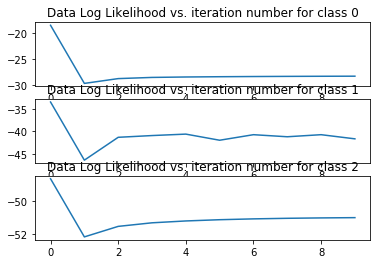

In [29]:
for y in range(0,3):
    # Perform Expectation Maximization for the y'th class
    # Start out with the parameters from k-means
    c_em = c_gmm
    mu_em = mu_gmm
    Sigma_em = Sigma_gmm
    Xy = X[50*y:50*(y+1),0:2]
    data_loglikelihood = []
    
    # Now iterate ten times (we won't check convergence, but we'll check how the data log likelihood evolves)
    for iteration_count in range(0,10):
        # Create an array of the random variables
        rvs = [ stats.multivariate_normal(mu_em[y,0,:],Sigma_em[y,0,:,:]),
                  stats.multivariate_normal(mu_em[y,1,:], Sigma_em[y,1,:,:]) ]

        # Accumulate sufficient statistics for the numerator of each parameter's M-step
        c_numerator = np.zeros(2)
        mu_numerator = np.zeros((2,2))
        Sigma_numerator = np.zeros((2,2,2))
                                
        # E-step: calculate the gamma probability, and the sufficient statistics
        gamma_denom = np.zeros(50)
        for n in range(0,50):
            gamma_denom[n] = np.inner(c_em[y,:], [rvs[0].pdf(Xy[n,:]), rvs[1].pdf(Xy[n,:]) ] )
            for k in range(0,2):
                gamma = c_em[y,k]*rvs[k].pdf(Xy[n,:])/gamma_denom[n]
                c_numerator[k] = c_numerator[k] + gamma
                mu_numerator[k,:] = mu_numerator[k,:] + gamma*Xy[n,:]
                Sigma_numerator[k,:,:] = Sigma_numerator[k,:,:] + gamma*np.outer(Xy[n,:],Xy[n,:])

        # M-step: re-compute the parameters
        for k in range(0,2):
            c_em[y,k] = c_numerator[k] / 50
            mu_em[y,k,:] = mu_numerator[k,:] / c_numerator[k]
            Sigma_em[y,k,:,:] = Sigma_numerator[k,:,:] / c_numerator[k] - np.outer(mu_em[y,k,:],mu_em[y,k,:])
            # Make sure sigma is positive definite
            d = np.linalg.det(Sigma_em[y,k,:,:])
            if d < 0.001:
                sqrtd = np.sqrt(0.01-d)
                Sigma_em[y,k,:,:] = Sigma_em[y,k,:,:] + sqrtd*np.eye(2)
                
        # Re-calculate log likelihood
        data_loglikelihood.append( np.sum(np.log(gamma_denom)) )

    # After convergence, plot data_loglikelihood
    plt.subplot(3,1,y+1)
    plt.plot(data_loglikelihood)
    plt.title('Data Log Likelihood vs. iteration number for class {}'.format(y))

Sigma_em


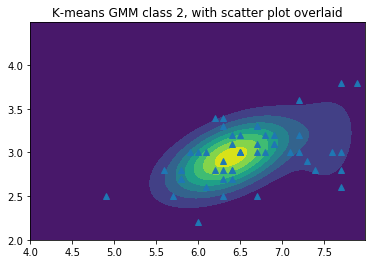

In [30]:
# Now let's calculate the GMM model of each of the three classes
em_gaussians = np.empty((400,250,3,2))
em_pdf = np.zeros((400,250,3))
for y in range(0,3):
    for k in range(0,2):
        em_gaussians[:,:,y,k] = stats.multivariate_normal(mu_em[y,k,:],Sigma_em[y,k,:,:]).pdf(coords)
        em_pdf[:,:,y] = em_pdf[:,:,y] + c_em[y,k]*em_gaussians[:,:,y,k]

ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],em_pdf[:,:,2])
ax.plot(X[100:150,0],X[100:150,1],'^')
plt.title('K-means GMM class 2, with scatter plot overlaid')

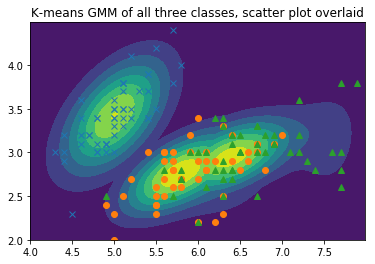

In [31]:
ax=plt.gca()
ax.contourf(coords[:,:,0],coords[:,:,1],np.amax(em_pdf,axis=2))
ax.plot(X[0:50,0],X[0:50,1],'x',X[50:100,0],X[50:100,1],'o',X[100:150,0],X[100:150,1],'^')
plt.title('K-means GMM of all three classes, scatter plot overlaid')

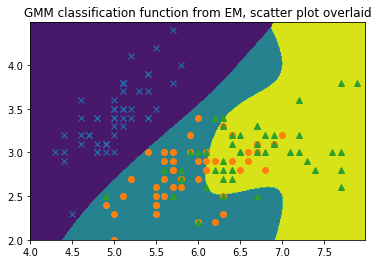

In [32]:
ax=plt.gca()
maxpdf = np.amax(em_pdf, axis=2)
yhat_using_em = (maxpdf == em_pdf[:,:,1]) + 2*(maxpdf == em_pdf[:,:,2])
ax.contourf(coords[:,:,0],coords[:,:,1],yhat_using_em)
ax.plot(X[0:50,0],X[0:50,1],'x',X[50:100,0],X[50:100,1],'o',X[100:150,0],X[100:150,1],'^')
plt.title('GMM classification function from EM, scatter plot overlaid')